Biodiversity in US National Parks
Project Scope

1. How many species per category?
2. Break-down of categories per conservation status
3. Which category is most likely to be endangered?
4. How many observations per category?
5. What's the most common animal?
6. Chi squared - sneak peek and refresher

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#creating dataframes
species_info = pd.read_csv('species_info.csv',encoding='utf-8')
species_info.drop_duplicates(keep='first', inplace=True)
observations = pd.read_csv('observations.csv',encoding='utf-8')
observations.drop_duplicates(keep='first', inplace=True)

### Inspecting 'species_info.csv'

'species_info.csv' consists pf 5824 entries and describes animals and plants by listing their (1) category, (2) scientific name, (3) common name(s) and (4) their conservation status. Some initial insights:
* the conservation status has a lot of null values
* some scientific names are duplicated (5541 unique scientific names vs. 5824 entries in the dataset)

In [3]:
print('##################################')
print('General info:')
print(species_info.info())
print('##################################')
print('Column names and data types:')
print(species_info.dtypes)
print('##################################')
print('Number of rows and columns:')
print(species_info.shape)
print('##################################')
print('Conservation status values:')
print(species_info.conservation_status.unique())
print('##################################')
print('Animal/plant categories:')
print(species_info.category.unique())
print('##################################')
print('How many animals/plants')
print(len(observations.scientific_name.unique()))
print('##################################')
print('Sample of the dataframe:')
species_info.head()


##################################
General info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5824 entries, 0 to 5823
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   category             5824 non-null   object
 1   scientific_name      5824 non-null   object
 2   common_names         5824 non-null   object
 3   conservation_status  191 non-null    object
dtypes: object(4)
memory usage: 227.5+ KB
None
##################################
Column names and data types:
category               object
scientific_name        object
common_names           object
conservation_status    object
dtype: object
##################################
Number of rows and columns:
(5824, 4)
##################################
Conservation status values:
[nan 'Species of Concern' 'Endangered' 'Threatened' 'In Recovery']
##################################
Animal/plant categories:
['Mammal' 'Bird' 'Reptile' 'Amphibian' 'Fis

,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN
1,Mammal,Bos bison,"American Bison, Bison",NaN
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",NaN
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",NaN
4,Mammal,Cervus elaphus,Wapiti Or Elk,NaN


According to the information provided along with the dataset, the missing information about the conservation status denotes the species is of no concern. The nan values have thus been filled as "Species of no concern". Additionally, the conservation status values have been reorganized into ordered categories with "Endangared" at the bottom and "Species of no concern" at the top.

In [4]:
#filling in nans
species_info['conservation_status'] = species_info['conservation_status'].fillna('Species of no concern')

#creating categorical data out of conservation status
species_info["conservation_status"] = species_info["conservation_status"].astype("category")
species_info["conservation_status"] = species_info["conservation_status"].cat.reorder_categories(['Endangered', 'Threatened', 'Species of Concern', 'In Recovery', 'Species of no concern'], ordered=True)

#checking uniques
print(species_info.conservation_status.unique())

['Species of no concern', 'Species of Concern', 'Endangered', 'Threatened', 'In Recovery']
Categories (5, object): ['Endangered' < 'Threatened' < 'Species of Concern' < 'In Recovery' < 'Species of no concern']


The duplicated scientific names are due to inconsistent use of common names, as seen below. These entries will stay as is and should not affect our analysis.

In [5]:
species_info['duplicate'] = species_info.duplicated(subset=['scientific_name'],keep=False)
#creating a temporary df with only duplicate entries
species_info_dup = species_info[species_info.duplicate == True].reset_index()
#dropping the duplicate column from the main df
species_info.drop(labels='duplicate', axis=1, inplace=True)
species_info_dup.sort_values(by='scientific_name', inplace=True, ascending=False)
#checking a few duplicated entries
species_info_dup.head(10)


,index,category,scientific_name,common_names,conservation_status,duplicate
319,3347,Vascular Plant,Zizia aptera,"Heartleaf Alexanders, Heart-Leaf Alexanders, M...",Species of no concern,True
56,632,Vascular Plant,Zizia aptera,Golden Alexanders,Species of no concern,True
441,4290,Vascular Plant,Vulpia octoflora,"Eight-Flower Six-Weeks Grass, Pullout Grass, S...",Species of no concern,True
233,2331,Vascular Plant,Vulpia octoflora,Annual Fescue,Species of no concern,True
232,2330,Vascular Plant,Vulpia myuros,Rattail Fescue,Species of no concern,True
555,5643,Vascular Plant,Vulpia myuros,"Foxtail Fescue, Rattail Fescue, Rat-Tail Fescu...",Species of no concern,True
554,5640,Vascular Plant,Vulpia bromoides,"Brome Fescue, Brome Six-Weeks Grass, Desert Fe...",Species of no concern,True
231,2329,Vascular Plant,Vulpia bromoides,Fescue,Species of no concern,True
37,328,Bird,Vireo solitarius,"Blue-Headed Vireo, Solitary Vireo",Species of no concern,True
297,3231,Bird,Vireo solitarius,Blue-Headed Vireo,Species of no concern,True


In [6]:
species_info.sort_values(by='conservation_status', inplace=True, ascending=True)
species_info.drop_duplicates(subset='scientific_name', keep='first', inplace=True)

In [7]:
def kingdom_check(x):
    if x in ['Vascular Plant', 'Nonvascular Plant']:
        return 'Plant'
    else:
        return 'Animal'
species_info['Kingdom'] = species_info.category.apply(kingdom_check)
species_info.head()

,category,scientific_name,common_names,conservation_status,Kingdom
3275,Fish,Chasmistes liorus,June Sucker,Endangered,Animal
4448,Mammal,Canis lupus,"Gray Wolf, Wolf",Endangered,Animal
34,Mammal,Myotis grisescens,Gray Myotis,Endangered,Animal
540,Fish,Etheostoma percnurum,Duskytail Darter,Endangered,Animal
173,Bird,Grus americana,Whooping Crane,Endangered,Animal


### Inspecting 'observations.csv'

'observations.csv' lists sightings of individual species including (1) their scientific name, (2) the park name that reported the sightings, (3) the total number of reported sightings (i.e. observations) for the given entry. No modifications of the dataset are necessary.

In [8]:
#taking a first look at the observations df
print('##################################')
print('General info:')
print(observations.info())
print('##################################')
print('Column names and data types:')
print(observations.dtypes)
print('##################################')
print('Number of rows and columns:')
print(observations.shape)
print('##################################')
print('List park names')
print(observations.park_name.unique())
print('##################################')
print('The number of unique scientific_names is equal between the two DFs:')
print(len(species_info.scientific_name.unique())==len(observations.scientific_name.unique()))
print('##################################')
print('Sample of the DF:')
observations.head()


##################################
General info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 23281 entries, 0 to 23295
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   scientific_name  23281 non-null  object
 1   park_name        23281 non-null  object
 2   observations     23281 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 727.5+ KB
None
##################################
Column names and data types:
scientific_name    object
park_name          object
observations        int64
dtype: object
##################################
Number of rows and columns:
(23281, 3)
##################################
List park names
['Great Smoky Mountains National Park' 'Yosemite National Park'
 'Bryce National Park' 'Yellowstone National Park']
##################################
The number of unique scientific_names is equal between the two DFs:
True
##################################
Sample of the DF:


,scientific_name,park_name,observations
0,Vicia benghalensis,Great Smoky Mountains National Park,68
1,Neovison vison,Great Smoky Mountains National Park,77
2,Prunus subcordata,Yosemite National Park,138
3,Abutilon theophrasti,Bryce National Park,84
4,Githopsis specularioides,Great Smoky Mountains National Park,85


# Analysis
## Species per category

In [9]:
species_info.shape[0]
species_grouping = species_info.groupby('category').size().reset_index()
species_grouping.columns= ['category', 'Count']
species_grouping['Percentage'] = species_grouping.Count / species_info.shape[0] * 100
species_grouping

,category,Count,Percentage
0,Amphibian,79,1.425735
1,Bird,488,8.807075
2,Fish,125,2.255910
3,Mammal,176,3.176322
4,Nonvascular Plant,333,6.009746
5,Reptile,78,1.407688
6,Vascular Plant,4262,76.917524


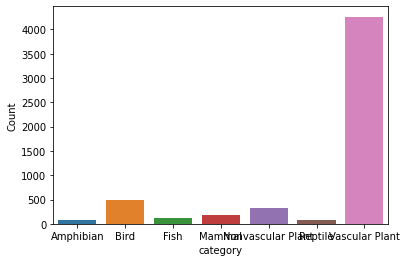

<Figure size 432x288 with 0 Axes>

In [10]:
sns.barplot(data=species_grouping, x="category", y='Count')
plt.show()
plt.clf()

In [11]:
species_grouping_animals = species_info[species_info.Kingdom =='Animal'].groupby('category').size().reset_index()
species_grouping_animals.columns= ['category', 'Count']
species_grouping_animals['Percentage'] = species_grouping_animals.Count / species_info[species_info.Kingdom =='Animal'].shape[0] * 100
species_grouping_animals

,category,Count,Percentage
0,Amphibian,79,8.350951
1,Bird,488,51.585624
2,Fish,125,13.213531
3,Mammal,176,18.604651
4,Reptile,78,8.245243


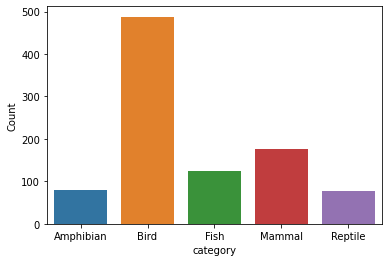

<Figure size 432x288 with 0 Axes>

In [12]:
sns.barplot(data=species_grouping_animals, x="category", y='Count')
plt.show()
plt.clf()

In [13]:
species_grouping_plants = species_info[species_info.Kingdom =='Plant'].groupby('category').size().reset_index()
species_grouping_plants.columns= ['category', 'Count']
species_grouping_plants['Percentage'] = species_grouping_plants.Count / species_info[species_info.Kingdom =='Plant'].shape[0] * 100
species_grouping_plants

,category,Count,Percentage
0,Nonvascular Plant,333,7.247008
1,Vascular Plant,4262,92.752992


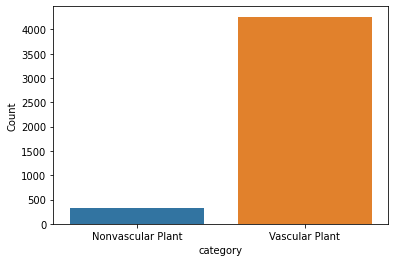

<Figure size 432x288 with 0 Axes>

In [14]:
sns.barplot(data=species_grouping_plants, x="category", y='Count')
plt.show()
plt.clf()

## Categories per conservation status

In [15]:

species_info['IsProtected'] = species_info.conservation_status != 'Species of no concern'
species_grouping = species_info.groupby(['category','IsProtected']).scientific_name.nunique().reset_index()\
                        .pivot(columns='IsProtected',
                                      index='category',
                                      values='scientific_name')\
                        .reset_index()
species_grouping.columns = ['Category', 'Not Protected', 'Protected']
species_grouping['% of protected'] = species_grouping.Protected / (species_grouping.Protected + species_grouping['Not Protected']) * 100

species_grouping

,Category,Not Protected,Protected,% of protected
0,Amphibian,72,7,8.860759
1,Bird,413,75,15.368852
2,Fish,114,11,8.800000
3,Mammal,146,30,17.045455
4,Nonvascular Plant,328,5,1.501502
5,Reptile,73,5,6.410256
6,Vascular Plant,4216,46,1.079305


In [16]:
#needed to bring back the object category to the conservation status
species_info["conservation_status"] = species_info["conservation_status"].astype("object")
cat_per_cons_status = species_info[species_info.conservation_status != 'Species of no concern']\
    .groupby(["conservation_status", "category"])['scientific_name']\
    .count()\
    .unstack()

cat_per_cons_status

category,Amphibian,Bird,Fish,Mammal,Nonvascular Plant,Reptile,Vascular Plant
conservation_status,,,,,,,
Endangered,1.0,4.0,3.0,6.0,NaN,NaN,1.0
In Recovery,NaN,3.0,NaN,NaN,NaN,NaN,NaN
Species of Concern,4.0,68.0,4.0,22.0,5.0,5.0,43.0
Threatened,2.0,NaN,4.0,2.0,NaN,NaN,2.0


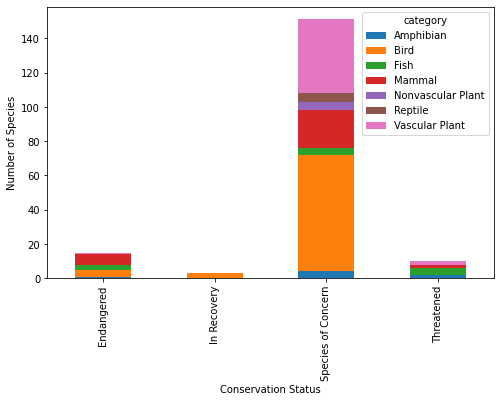

In [17]:
ax = cat_per_cons_status.plot(kind = 'bar', figsize=(8,5), 
                               stacked=True)
ax.set_xlabel("Conservation Status")
ax.set_ylabel("Number of Species");

## Analysis of park observations

In [18]:
all_data = pd.merge(
    left = observations,
    right = species_info,
    left_on = 'scientific_name',
    right_on = 'scientific_name',
    how='left')


print(all_data.info())
all_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23281 entries, 0 to 23280
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   scientific_name      23281 non-null  object
 1   park_name            23281 non-null  object
 2   observations         23281 non-null  int64 
 3   category             23281 non-null  object
 4   common_names         23281 non-null  object
 5   conservation_status  23281 non-null  object
 6   Kingdom              23281 non-null  object
 7   IsProtected          23281 non-null  bool  
dtypes: bool(1), int64(1), object(6)
memory usage: 1.4+ MB
None


,scientific_name,park_name,observations,category,common_names,conservation_status,Kingdom,IsProtected
0,Vicia benghalensis,Great Smoky Mountains National Park,68,Vascular Plant,"Purple Vetch, Reddish Tufted Vetch",Species of no concern,Plant,False
1,Neovison vison,Great Smoky Mountains National Park,77,Mammal,American Mink,Species of no concern,Animal,False
2,Prunus subcordata,Yosemite National Park,138,Vascular Plant,Klamath Plum,Species of no concern,Plant,False
3,Abutilon theophrasti,Bryce National Park,84,Vascular Plant,Velvetleaf,Species of no concern,Plant,False
4,Githopsis specularioides,Great Smoky Mountains National Park,85,Vascular Plant,Common Bluecup,Species of no concern,Plant,False


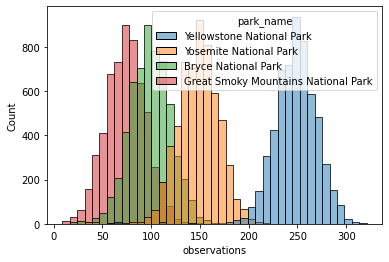

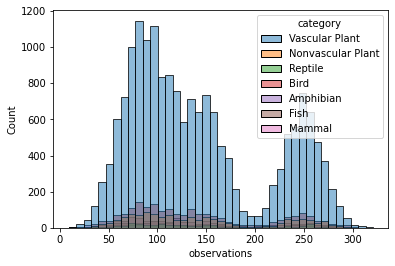

<Figure size 432x288 with 0 Axes>

In [32]:
#check the shape of observations


sns.histplot(data=all_data, x='observations', hue='park_name')
plt.show()
plt.clf()

#Number of unique species per park
species_per_park = all_data.groupby('park_name').count().reset_index()
species_per_park


##these are probably obsolete
sns.histplot(data=all_data, x='observations', hue='category')
plt.show()
plt.clf()

# data_filtered = all_data[all_data.Kingdom == 'Animal']

# sns.histplot(data=data_filtered, x='observations', hue='category')
# plt.show()
# plt.clf()




In [27]:
species_per_park_ob = observations.drop('observations',axis=1).groupby('park_name').count().reset_index()
species_per_park_ob.drop_duplicates(keep='first', inplace=True)
species_per_park_ob

,park_name,scientific_name
0,Bryce National Park,5823
1,Great Smoky Mountains National Park,5818
2,Yellowstone National Park,5819
3,Yosemite National Park,5821


                             park_name  observations
0                  Bryce National Park     98.901082
1  Great Smoky Mountains National Park     74.145411
2            Yellowstone National Park    247.862863
3               Yosemite National Park    148.228139


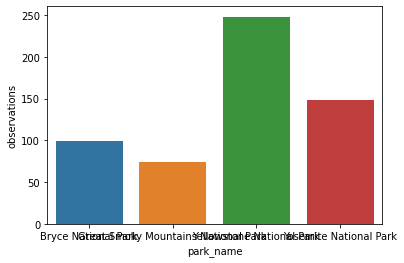

<Figure size 432x288 with 0 Axes>

In [28]:
#check how many entries per park

# #no. of entries
# df_counts = observations.drop("scientific_name", axis = 1).groupby("park_name").count().reset_index()
# print(df_counts)
# sns.barplot(data=df_counts, x="park_name", y='observations')
# plt.show()
# plt.clf()
#mean no. of observations
df_means = observations.drop("scientific_name", axis = 1).groupby("park_name").mean().reset_index()
print(df_means)
sns.barplot(data=df_means, x="park_name", y='observations')
plt.show()
plt.clf()

# #total no. of observations
# df_sums = observations.drop("scientific_name", axis = 1).groupby("park_name").sum().reset_index()
# print(df_sums)
# sns.barplot(data=df_sums, x="park_name", y='observations')
# plt.show()
# plt.clf()


            category  observations  IsProtected
0          Amphibian    137.409375     0.087500
1               Bird    140.459914     0.151704
2               Fish    139.405512     0.094488
3             Mammal    136.187135     0.177778
4  Nonvascular Plant    143.132883     0.015015
5            Reptile    141.386076     0.063291
6     Vascular Plant    142.905412     0.010298


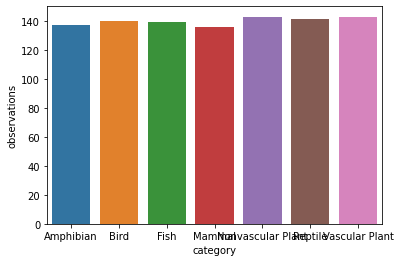

     conservation_status  observations  IsProtected
0             Endangered     41.147059          1.0
1            In Recovery    116.000000          1.0
2     Species of Concern    128.228261          1.0
3  Species of no concern    143.131568          0.0
4             Threatened     75.886364          1.0


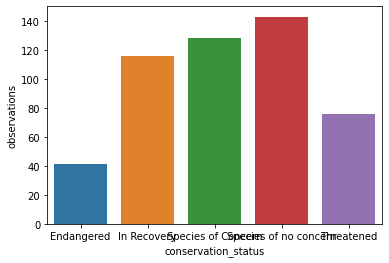

<Figure size 432x288 with 0 Axes>

In [33]:
# #check % of different animal categories in the total number of entries
# df_counts = all_data.drop(["scientific_name", "park_name", "conservation_status"], axis = 1).groupby("category").count().reset_index()
# print(df_counts)
# sns.barplot(data=df_counts, x="category", y='observations')
# plt.show()
# plt.clf()

# #check % of different animal categories in the total number of entries
# df_counts = all_data.drop(["scientific_name", "park_name", "conservation_status"], axis = 1).groupby("category").sum().reset_index()
# print(df_counts)
# sns.barplot(data=df_counts, x="category", y='observations')
# plt.show()
# plt.clf()

#mean no. of observations per category
df_counts = all_data.drop(["park_name", "conservation_status"], axis = 1).groupby("category").mean().reset_index()
print(df_counts)
sns.barplot(data=df_counts, x="category", y='observations')
plt.show()
plt.clf()

#mean no. of observations per conservation status
df_counts = all_data.drop(["park_name", "category"], axis = 1).groupby("conservation_status").mean().reset_index()
print(df_counts)
sns.barplot(data=df_counts, x="conservation_status", y='observations')
plt.show()
plt.clf()

AttributeError: 'Rectangle' object has no property 'hue'

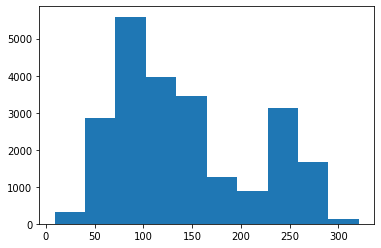

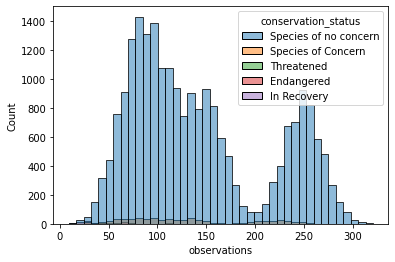

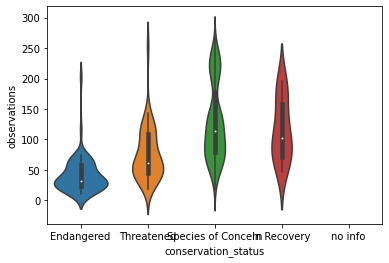

In [23]:
#check relationship between status and observations


sns.histplot(x = 'observations', data = all_data[all_data.conservation_status != 'no info'], hue='conservation_status')
plt.show()
plt.clf()
sns.violinplot(x='conservation_status', y='observations', data = all_data, order=['Endangered', 'Threatened', 'Species of Concern', 'In Recovery', 'no info'])
plt.show()




NameError: name 'men_means' is not defined

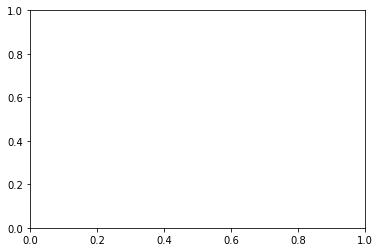

In [24]:
#check relationship between status and park


status = all_data.conservation_status
parks = all_data.park_name.unique()
width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

ax.bar(parks, men_means, width, label='Men')
ax.bar(parks, women_means, width, bottom=men_means,
       label='Women')


#check relationship between status and animal category